# Final Project of Graph Learning

Codes due to Su Baozhuo, 2026.01.

Please noting that the notebook are experiments code of the final project, it is only used to get results and generate figures, all the anlyses can be found in the report.




## Prémable et data loading from google drive

In [138]:
# @title
import os
import random
from abc import ABC, abstractmethod


import numpy as np
import pandas as pd
from collections import deque

import matplotlib.pyplot as plt
import seaborn as sns


import networkx as nx
from networkx.algorithms.community.quality import modularity


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin

import progressbar
from matplotlib.patches import Ellipse


## If the data is loading from local, then this can be skipped

In [3]:
# @title
# Link Google drive to download data
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/M2')
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/M2


# Functions may be used

In [ ]:
# @title
def precision_recall(topk, dele_set):
    hit = 0
    for (edge, _) in topk:
        e = (min(edge[0], edge[1]), max(edge[0], edge[1]))
        if e in dele_set:
            hit += 1
    precision = hit / len(topk) * 100 if len(topk) else 0.0
    recall = hit / len(dele_set) * 100 if len(dele_set) else 0.0
    return hit, precision, recall


def plot_precision_recall_curves(dataset_name, k_list, precision_dict, recall_dict,
                                 methods=("Common", "Jaccard", "Adamic")):

    fig, (ax_p, ax_r) = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

    # Precision vs k
    for m in methods:
        y = [precision_dict.get((k, m), None) for k in k_list]
        ax_p.plot(k_list, y, marker='o', label=m)
    ax_p.set_title(f"{dataset_name} - Precision vs K")
    ax_p.set_xlabel("K")
    ax_p.set_ylabel("Precision (%)")
    ax_p.grid(True, alpha=0.3)
    ax_p.legend()

    # Recall vs k
    for m in methods:
        y = [recall_dict.get((k, m), None) for k in k_list]
        ax_r.plot(k_list, y, marker='o', label=m)
    ax_r.set_title(f"{dataset_name} - Recall vs K")
    ax_r.set_xlabel("K")
    ax_r.set_ylabel("Recall (%)")
    ax_r.grid(True, alpha=0.3)
    ax_r.legend()

    fig.suptitle(dataset_name, y=1.05)
    fig.tight_layout()
    return fig


def label_propagation(G, label_attr: str, remove_fraction: float, iteration_round: int, seed: int = 0):
    rng = random.Random(seed)

    Gc = G.copy()
    nodes_all = list(Gc.nodes())
    num_remove = round(len(nodes_all) * remove_fraction)
    deleted_nodes = set(rng.sample(nodes_all, num_remove))

    for n in deleted_nodes:
        Gc.nodes[n].pop(label_attr, None)

    labeled_nodes = [n for n in nodes_all if label_attr in Gc.nodes[n]]
    unlabeled_nodes = [n for n in nodes_all if label_attr not in Gc.nodes[n]]

    classes = sorted({Gc.nodes[n][label_attr] for n in labeled_nodes})
    C = len(classes)
    cls2id = {c: i for i, c in enumerate(classes)}
    id2cls = {i: c for c, i in cls2id.items()}

    nodelist = labeled_nodes + unlabeled_nodes
    n = len(nodelist)
    idx = {node: i for i, node in enumerate(nodelist)}
    l = len(labeled_nodes)

    W = nx.to_numpy_array(Gc, nodelist=nodelist, weight=None)
    d = W.sum(axis=1)
    T = np.zeros_like(W, dtype=float)
    nz = d > 0
    T[nz, :] = W[nz, :] / d[nz, None]

    P = T.copy()
    P[:l, :] = 0.0
    P[np.arange(l), np.arange(l)] = 1.0

    Y0 = np.zeros((n, C), dtype=float)
    for node in labeled_nodes:
        i = idx[node]
        Y0[i, cls2id[Gc.nodes[node][label_attr]]] = 1.0

    Y = Y0.copy()
    for _ in range(iteration_round):
        Y = P @ Y
        Y[:l, :] = Y0[:l, :]

    pred_ids = np.argmax(Y[l:, :], axis=1)
    pred_labels = {unlabeled_nodes[i]: id2cls[int(pred_ids[i])] for i in range(len(unlabeled_nodes))}

    #accuracy
    correct_pred=0
    valid=0
    for node in unlabeled_nodes:
       if label_attr in G.nodes[node]:
         valid+=1
         if G.nodes[node][label_attr]==pred_labels[node]:
           correct_pred+=1
    accuracy=correct_pred/valid if valid!=0 else 0


    return Y, pred_labels, labeled_nodes, unlabeled_nodes, classes,accuracy


# Quesyion 2 : Social Network Analysis with the Facebook100 Dataset

In [52]:
# Data load from google drive, it can also be loaded locally

caltech=nx.read_gml('data/Caltech36.gml')
mit=nx.read_gml('data/MIT8.gml')
johnsHop=nx.read_gml('data/Johns Hopkins55.gml')
print(caltech.number_of_nodes())
print(mit.number_of_nodes())
print(johnsHop.number_of_nodes())


769
6440
5180


In [ ]:
sorted_caltech=sorted(dict(caltech.degree()).items(), key=lambda x: x[0])
sorted_caltech
degree=[]
for i in sorted_caltech:
  degree.append(i[1])
D=np.diag(degree)
D
#

array([[124,   0,   0, ...,   0,   0,   0],
       [  0,  54,   0, ...,   0,   0,   0],
       [  0,   0,   2, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   4,   0,   0],
       [  0,   0,   0, ...,   0,   1,   0],
       [  0,   0,   0, ...,   0,   0,   1]])

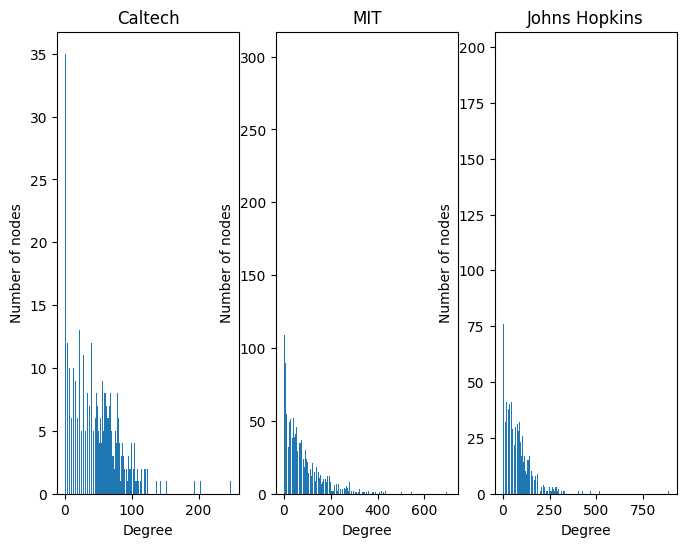

In [ ]:
# Degree distribution
degree_sequence_caltech=sorted((d for n,d in caltech.degree()), reverse=True)
degree_sequence_mit=sorted((d for n,d in mit.degree()), reverse=True)
degree_sequence_johnsHop=sorted((d for n,d in johnsHop.degree()), reverse=True)

dmax_caltech=max(degree_sequence_caltech)
dmax_mit=max(degree_sequence_mit)
dmax_johnsHop=max(degree_sequence_johnsHop)

fig=plt.figure('Degree of Caltech, MIT and John Hopkins', figsize=(8,6))
axgrid=fig.add_gridspec(1,3)

ax0=fig.add_subplot(axgrid[0,0])
ax0.bar(*np.unique(degree_sequence_caltech, return_counts=True))
ax0.set_title('Caltech')

ax1=fig.add_subplot(axgrid[0,1])
ax1.bar(*np.unique(degree_sequence_mit, return_counts=True))
ax1.set_title('MIT')

ax2=fig.add_subplot(axgrid[0,2])
ax2.bar(*np.unique(degree_sequence_johnsHop, return_counts=True))
ax2.set_title('Johns Hopkins')

ax0.set_xlabel('Degree')
ax0.set_ylabel('Number of nodes')

ax1.set_xlabel('Degree')
ax1.set_ylabel('Number of nodes')

ax2.set_xlabel('Degree')
ax2.set_ylabel('Number of nodes')
plt.show()



In [ ]:
# compute loca clustering coefficient

coeff_caltech=nx.clustering(caltech)
coeff_mit=nx.clustering(mit)
coeff_johnsHop=nx.clustering(johnsHop)

#coeff_caltech
#coeff_mit
#coeff_johnsHop

coeff_global_caltech=nx.transitivity(caltech)
coeff_global_mit=nx.transitivity(mit)
coeff_global_johnsHop=nx.transitivity(johnsHop)

In [ ]:
print('global_caltech:', coeff_global_caltech)
print('global_mit:', coeff_global_mit)
print('global_JH:', coeff_global_johnsHop)

global_caltech: 0.2912826901150874
global_mit: 0.18028845093502427
global_JH: 0.19316123901594015


In [ ]:
# denstity of edges
denstiy_caltech=nx.density(caltech)
denstiy_mit=nx.density(mit)
denstiy_johnsHop=nx.density(johnsHop)

print('denstiy_caltech:', denstiy_caltech)
print('denstiy_mit:', denstiy_mit)
print('denstiy_johnsHop:', denstiy_johnsHop)

denstiy_caltech: 0.05640442132639792
denstiy_mit: 0.012118119495041378
denstiy_johnsHop: 0.013910200162372396


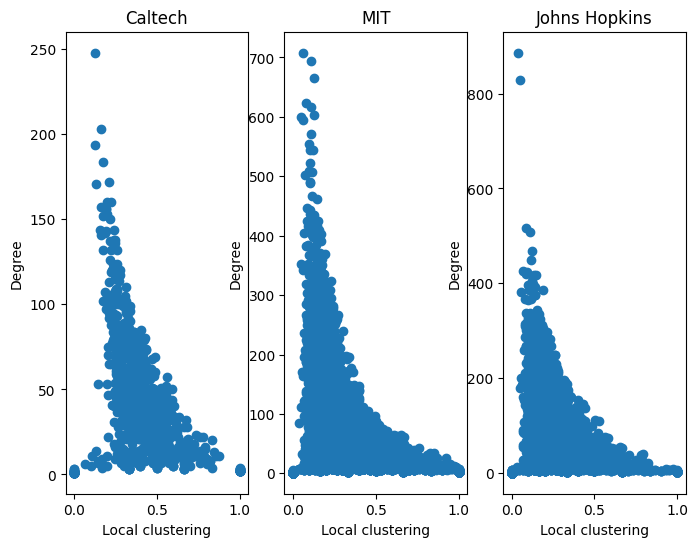

In [ ]:
# plot of degree vs local clustering
degree_list_caltech=list(caltech.degree())
degree_list_mit=list(mit.degree())
degree_list_johnsHop=list(johnsHop.degree())

X_caltech=[]
X_mit=[]
X_johnsHop=[]
for i in degree_list_caltech:
  X_caltech.append(i[1])
for  i in degree_list_mit:
  X_mit.append(i[1])
for i in degree_list_johnsHop:
  X_johnsHop.append(i[1])

Y_caltech=[]
Y_mit=[]
Y_johnsHop=[]

#print(coeff_caltech.values())
for i in coeff_caltech.values():
  Y_caltech.append(i)

for i in coeff_mit.values():
  Y_mit.append(i)

for i in coeff_johnsHop.values():
  Y_johnsHop.append(i)

fig=plt.figure('Degree vs Local clsutering coefficient', figsize=(8,6))
axgrid=fig.add_gridspec(1,3)
ax0=fig.add_subplot(axgrid[0,0])
ax0.scatter(Y_caltech, X_caltech)
ax0.set_title('Caltech')

ax1=fig.add_subplot(axgrid[0,1])
ax1.scatter(Y_mit, X_mit)
ax1.set_title('MIT')

ax2=fig.add_subplot(axgrid[0,2])
ax2.scatter(Y_johnsHop, X_johnsHop)
ax2.set_title('Johns Hopkins')

ax0.set_xlabel('Local clustering')
ax0.set_ylabel('Degree')

ax1.set_xlabel('Local clustering')
ax1.set_ylabel('Degree')


ax2.set_xlabel('Local clustering')
ax2.set_ylabel('Degree')

plt.show()

# Q3 Assortativity Analysis with the Facebook100 Dataset

In order to reduce computation, we only analysis Caltech, MIT and JH dataset

In [ ]:
# compute assortavity of status
node_attr_keys=set().union(*(d.keys() for _,d in caltech.nodes(data=True)))
node_attr_keys

{'dorm',
 'gender',
 'high_school',
 'major_index',
 'second_major',
 'student_fac',
 'year'}

In [ ]:
print(nx.attribute_assortativity_coefficient(caltech, "gender"))

0.04633143645586916


In [ ]:
os.chdir('/content/drive/MyDrive/M2/data')

['Williams40.gml', 'Princeton12.gml', 'Simmons81.gml', 'UGA50.gml', 'Virginia63.gml', 'Harvard1.gml', 'Wesleyan43.gml', 'UC33.gml', 'WashU32.gml', 'Villanova62.gml', 'Auburn71.gml', 'Haverford76.gml', 'Oklahoma97.gml', 'Brandeis99.gml', 'Tulane29.gml', 'Wisconsin87.gml', 'Emory27.gml', 'Mich67.gml', 'Michigan23.gml', 'Maryland58.gml', 'Amherst41.gml', 'American75.gml', 'Northeastern19.gml', 'UMass92.gml', 'Trinity100.gml', 'Stanford3.gml', 'Dartmouth6.gml', 'Georgetown15.gml', 'BU10.gml', 'Northwestern25.gml', 'BC17.gml', 'Texas80.gml', 'Cornell5.gml', 'Hamilton46.gml', 'Vermont70.gml', 'USC35.gml', 'UNC28.gml', 'Penn94.gml', 'NYU9.gml', 'Tennessee95.gml', 'Carnegie49.gml', 'UCF52.gml', 'UConn91.gml', 'Bucknell39.gml', 'Wake73.gml', 'Oberlin44.gml', 'FSU53.gml', 'Swarthmore42.gml', 'Temple83.gml', 'Syracuse56.gml', 'Colgate88.gml', 'Johns Hopkins55.gml', 'UCSB37.gml', 'Baylor93.gml', 'UPenn7.gml', 'Howard90.gml', 'Texas84.gml', 'UCSD34.gml', 'MU78.gml', 'UF21.gml', 'Columbia2.gml', 'Le

In [ ]:
# [0]-->dorm, [1]-->gender, [2]-->high_schol, [3]-->major_index, [4]-->second_major [5]-->year, [6]-->student_fac, [7]-->size


sub_data=['Caltech36.gml','MIT8.gml','Johns Hopkins55.gml']
dic={}
for g in sub_data:
  lst=[]
  key = g.split('.')[0]
  G=nx.read_gml(g)
  assort_dorm=nx.attribute_assortativity_coefficient(G, "dorm")
  assort_gender=nx.attribute_assortativity_coefficient(G, "gender")
  assort_high_school=nx.attribute_assortativity_coefficient(G, "high_school")
  assort_major=nx.attribute_assortativity_coefficient(G, "major_index")
  assort_second_major=nx.attribute_assortativity_coefficient(G, "second_major")
  assort_year=nx.attribute_assortativity_coefficient(G, "year")
  assort_student_fac=nx.attribute_assortativity_coefficient(G, "student_fac")
  size=G.size()

  lst.append(assort_dorm)
  lst.append(assort_gender)
  lst.append(assort_high_school)
  lst.append(assort_major)
  lst.append(assort_second_major)
  lst.append(assort_year)
  lst.append(assort_student_fac)
  lst.append(size)

  dic[key]=lst
  print('finish 1')

dic

finish 1
finish 1
finish 1


{'Caltech36': [0.3491531008726444,
  0.04633143645586916,
  0.0026697793065768648,
  0.03471942372358318,
  0.010674575827566271,
  0.2375319048128821,
  0.24407936743342126,
  16656],
 'MIT8': [0.17879641483565542,
  0.10637579721842909,
  0.014892520378939208,
  0.058067301827022307,
  0.010921515047006175,
  0.31038945304356547,
  0.315240859602468,
  251252],
 'Johns Hopkins55': [0.1094139656825041,
  0.08197009482543294,
  0.01232482961374995,
  0.06353066589182865,
  0.014350932565522329,
  0.37668118933810724,
  0.32521116673118183,
  186586]}

Text(0.5, 1.0, 'Size vs. Student Fac')

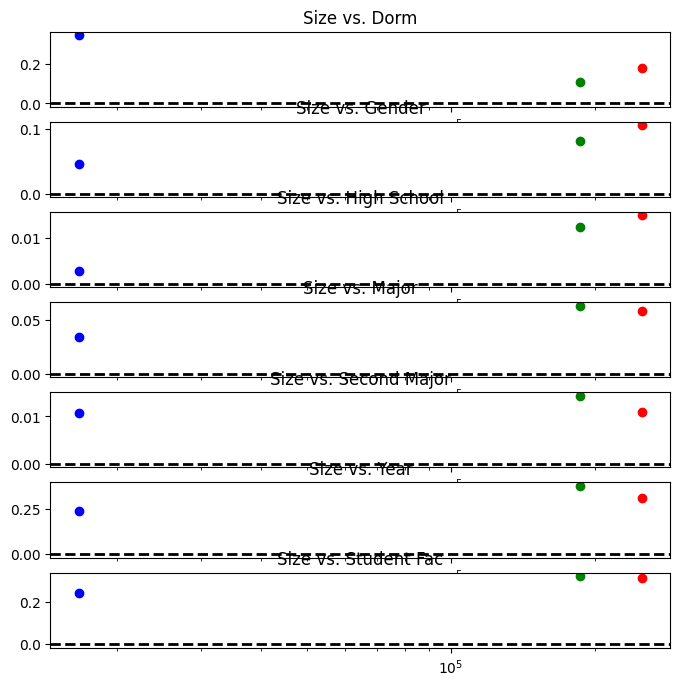

In [ ]:
# plot size vs assort, blue=caltech, red=MIT,green=JH
fig=plt.figure('Size vs Assortativity', figsize=(8,8))
axgrid=fig.add_gridspec(7 ,1)

ax0=fig.add_subplot(axgrid[0,0])
ax0.scatter(dic['Caltech36'][7], dic['Caltech36'][0],color='blue')
ax0.scatter(dic['MIT8'][7], dic['MIT8'][0], color='red')
ax0.scatter(dic['Johns Hopkins55'][7], dic['Johns Hopkins55'][0],color='green')
ax0.axhline(0,linestyle='--', linewidth=2,color='black')
ax0.set_xscale('log')
ax0.set_title('Size vs. Dorm')

ax1=fig.add_subplot(axgrid[1,0])
ax1.scatter(dic['Caltech36'][7], dic['Caltech36'][1],color='blue')
ax1.scatter(dic['MIT8'][7], dic['MIT8'][1],color='red')
ax1.scatter(dic['Johns Hopkins55'][7], dic['Johns Hopkins55'][1],color='green')
ax1.axhline(0,linestyle='--', linewidth=2,color='black')
ax1.set_xscale('log')
ax1.set_title('Size vs. Gender')


ax2=fig.add_subplot(axgrid[2,0])
ax2.scatter(dic['Caltech36'][7], dic['Caltech36'][2],color='blue')
ax2.scatter(dic['MIT8'][7], dic['MIT8'][2],color='red')
ax2.scatter(dic['Johns Hopkins55'][7], dic['Johns Hopkins55'][2],color='green')
ax2.axhline(0,linestyle='--', linewidth=2,color='black')
ax2.set_xscale('log')
ax2.set_title('Size vs. High School')


ax3=fig.add_subplot(axgrid[3,0])
ax3.scatter(dic['Caltech36'][7], dic['Caltech36'][3],color='blue')
ax3.scatter(dic['MIT8'][7], dic['MIT8'][3],color='red')
ax3.scatter(dic['Johns Hopkins55'][7], dic['Johns Hopkins55'][3],color='green')
ax3.axhline(0,linestyle='--', linewidth=2,color='black')
ax3.set_xscale('log')
ax3.set_title('Size vs. Major')

ax4=fig.add_subplot(axgrid[4,0])
ax4.scatter(dic['Caltech36'][7], dic['Caltech36'][4],color='blue')
ax4.scatter(dic['MIT8'][7], dic['MIT8'][4],color='red')
ax4.scatter(dic['Johns Hopkins55'][7], dic['Johns Hopkins55'][4],color='green')
ax4.axhline(0,linestyle='--', linewidth=2,color='black')
ax4.set_xscale('log')
ax4.set_title('Size vs. Second Major')

ax5=fig.add_subplot(axgrid[5,0])
ax5.scatter(dic['Caltech36'][7], dic['Caltech36'][5],color='blue')
ax5.scatter(dic['MIT8'][7], dic['MIT8'][5],color='red')
ax5.scatter(dic['Johns Hopkins55'][7], dic['Johns Hopkins55'][5],color='green')
ax5.axhline(0,linestyle='--', linewidth=2,color='black')
ax5.set_xscale('log')
ax5.set_title('Size vs. Year')

ax6=fig.add_subplot(axgrid[6,0])
ax6.scatter(dic['Caltech36'][7], dic['Caltech36'][6],color='blue')
ax6.scatter(dic['MIT8'][7], dic['MIT8'][6], color='red')
ax6.scatter(dic['Johns Hopkins55'][7], dic['Johns Hopkins55'][6],color='green')
ax6.axhline(0,linestyle='--', linewidth=2,color='black')
ax6.set_xscale('log')
ax6.set_title('Size vs. Student Fac')


Text(0.5, 1.0, 'Student Fac')

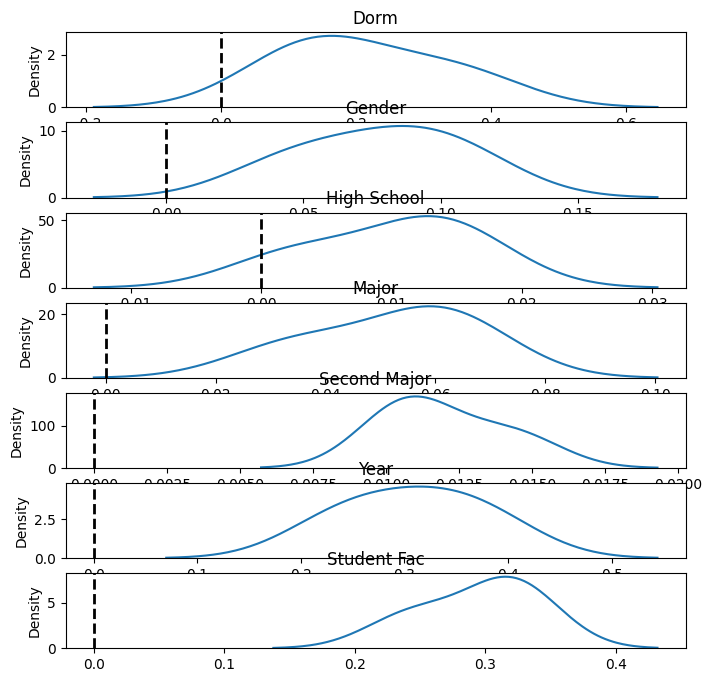

In [ ]:
data_gender=[dic['Caltech36'][1], dic['MIT8'][1], dic['Johns Hopkins55'][1]]
data_dorm=[dic['Caltech36'][0], dic['MIT8'][0], dic['Johns Hopkins55'][0]]
data_high_school=[dic['Caltech36'][2], dic['MIT8'][2], dic['Johns Hopkins55'][2]]
data_major=[dic['Caltech36'][3], dic['MIT8'][3], dic['Johns Hopkins55'][3]]
data_second_major=[dic['Caltech36'][4], dic['MIT8'][4], dic['Johns Hopkins55'][4]]
data_year=[dic['Caltech36'][5], dic['MIT8'][5], dic['Johns Hopkins55'][5]]
data_student_fac=[dic['Caltech36'][6], dic['MIT8'][6], dic['Johns Hopkins55'][6]]

fig=plt.figure('Assortativity Distribution', figsize=(8,8))
axgrid=fig.add_gridspec(7 ,1)

ax0=fig.add_subplot(axgrid[0,0])
sns.kdeplot(data_dorm,ax=ax0)
ax0.axvline(0,linestyle='--', linewidth=2,color='black')
ax0.set_title('Dorm')

ax1=fig.add_subplot(axgrid[1,0])
sns.kdeplot(data_gender,ax=ax1)
ax1.axvline(0,linestyle='--', linewidth=2,color='black')
ax1.set_title('Gender')

ax2=fig.add_subplot(axgrid[2,0])
sns.kdeplot(data_high_school,ax=ax2)
ax2.axvline(0,linestyle='--', linewidth=2,color='black')
ax2.set_title('High School')

ax3=fig.add_subplot(axgrid[3,0])
sns.kdeplot(data_major,ax=ax3)
ax3.axvline(0,linestyle='--', linewidth=2,color='black')
ax3.set_title('Major')

ax4=fig.add_subplot(axgrid[4,0])
sns.kdeplot(data_second_major,ax=ax4)
ax4.axvline(0,linestyle='--', linewidth=2,color='black')
ax4.set_title('Second Major')

ax5=fig.add_subplot(axgrid[5,0])
sns.kdeplot(data_year,ax=ax5)
ax5.axvline(0,linestyle='--', linewidth=2,color='black')
ax5.set_title('Year')

ax6=fig.add_subplot(axgrid[6,0])
sns.kdeplot(data_student_fac,ax=ax6)
ax6.axvline(0,linestyle='--', linewidth=2,color='black')
ax6.set_title('Student Fac')




# Q4 Link Prediction

In [ ]:
a=set(list(caltech.neighbors('3'))) & set(list(caltech.neighbors('4')))
print(list(a))

['708']


In [ ]:
class LinkPrediction(ABC):
    def __init__(self, graph):
        self.graph = graph
        self.N = len(graph)

    def neighbors(self, v):
        neighbors_list = self.graph.neighbors(v)
        return list(neighbors_list)

    @abstractmethod
    def fit(self):
      raise NotImplementedError
    @abstractmethod
    def score(self,u,v):
      raise NotImplementedError


class CommonNeighbors(LinkPrediction):
    def __init__(self, graph:nx.Graph):
        super(CommonNeighbors, self).__init__(graph)
        self.name = "CommonNeighbors"
    def fit(self):
      self._nbr_sets={n:set(self.graph.neighbors(n)) for n in self.graph.nodes()}
      return self
    def score(self, u,v):
        u_neighbors = self._nbr_sets[u]
        v_neighbors = self._nbr_sets[v]
        return len(u_neighbors & v_neighbors)


class Jaccard(LinkPrediction):
    def __init__(self, graph:nx.Graph):
        super(Jaccard, self).__init__(graph)
        self.name = "Jaccard"
    def fit(self):
      self._nbr_sets={n:set(self.graph.neighbors(n)) for n in self.graph.nodes()}
      return self

    def score(self, u,v):
        u_neighbors = self._nbr_sets[u]
        v_neighbors = self._nbr_sets[v]
        union=set(u_neighbors) | set(v_neighbors)
        if len(union) ==0:
          return 0
        return len((u_neighbors & v_neighbors))/len(union)

class Adamic(LinkPrediction):
    def __init__(self, graph:nx.Graph):
        super(Adamic, self).__init__(graph)
        self.name = "Adamic"
    def fit(self):
      self._nbr_sets={n:set(self.graph.neighbors(n)) for n in self.graph.nodes()}
      return self
    def score(self, u,v):
        u_neighbors = self._nbr_sets[u]
        v_neighbors = self._nbr_sets[v]
        intersection=set(u_neighbors)& set(v_neighbors)
        if len(intersection)==0:
          return 0
        s=0
        for i in intersection:
          deg=len(self._nbr_sets[i])
          if deg <=1:
            continue
          s+=1/np.log(deg)
        return s

In [ ]:
os.chdir('/content/drive/MyDrive/M2/data')
G_fb=nx.read_gml('Caltech36.gml')  # Caltech36, MIT8, Reed98
print(len(G_fb.nodes()))

769


In [ ]:
fraction=0.1 # [0.05, 0.1,0.15,0.2]

edges_list=list(G_fb.edges())
Dele_edges=random.sample(edges_list,round(len(edges_list)*fraction))

print(len(edges_list),len(Dele_edges))


16656 1666


In [ ]:
G_fb.remove_edges_from(Dele_edges)
print(len(list(G_fb.edges())))


14990


In [ ]:
# compute metrics
nodes = list(G_fb.nodes())
commonNeighbor=CommonNeighbors(G_fb).fit()
jacard=Jaccard(G_fb).fit()

adamic=Adamic(G_fb).fit()

score_common={}
score_jaccard={}
score_adamic={}

for i, u in enumerate(nodes):
  for v in nodes[i+1:]:
    key=(u,v)
    score_common[key]=commonNeighbor.score(u,v)
    score_jaccard[key]=jacard.score(u,v)
    score_adamic[key]=adamic.score(u,v)


score_common_sorted=sorted(score_common.items(),key=lambda x:x[1], reverse=True)
score_jaccard_sorted=sorted(score_jaccard.items(),key=lambda x:x[1], reverse=True)
score_adamic_sorted=sorted(score_adamic.items(),key=lambda x:x[1], reverse=True)

In [ ]:
Dele_edges_norm = set((min(u,v), max(u,v)) for (u,v) in Dele_edges)
k = [50,100,200,400]
caltech_precision={}
caltech_recall={}
for i in k:
  top_common  = score_common_sorted[:i]
  top_jaccard = score_jaccard_sorted[:i]
  top_adamic  = score_adamic_sorted[:i]

  hit, p, r = precision_recall(top_common, Dele_edges_norm)
  key=(i,'Common')
  caltech_precision[key]=p
  caltech_recall[key]=r


  hit, p, r = precision_recall(top_jaccard, Dele_edges_norm)
  key=(i,'Jaccard')
  caltech_precision[key]=p
  caltech_recall[key]=r

  hit, p, r = precision_recall(top_adamic, Dele_edges_norm)
  key=(i,'Adamic')
  caltech_precision[key]=p
  caltech_recall[key]=r





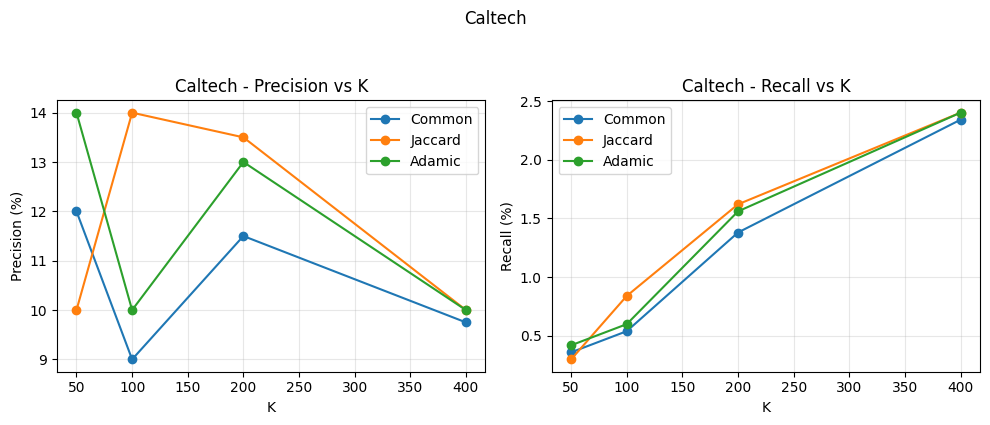

In [ ]:

k_list = [50, 100, 200, 400]
plot_precision_recall_curves("Caltech", k_list, caltech_precision, caltech_recall)
plt.show()


# Q5 Label Propagation Random Formulation

In [ ]:
#caltech
Y, pred_labels, labeled_nodes, unlabeled_nodes, classes,accuracy = label_propagation(
    G=caltech,
    label_attr='gender', # 'major_index' ; 'dorm'; 'year ' ; 'gender'
    remove_fraction=0.4, # 0.1,0.2,0.3,0.4,
    iteration_round=50,
)

print(accuracy)

0.5454545454545454


# Q5 Community detection and generation

# Pretraitement and Data splitting

## Function may be used in this part

In [67]:
# @title
def is_number(x):
    try:
        if x is None:
            return False
        float(x)
        return True
    except Exception:
        return False


def build_pairs(pairs_pos, pairs_neg):
    pairs = pairs_pos + pairs_neg
    y = np.array([1]*len(pairs_pos) + [0]*len(pairs_neg), dtype=np.float32)
    pairs = np.array(pairs, dtype=np.int64)
    return pairs, y

def pair_features(pairs_t):
    xi = X_t[pairs_t[:,0]]
    xj = X_t[pairs_t[:,1]]
    return torch.cat([xi, xj, xi*xj, torch.abs(xi-xj)], dim=1)

def sample_negative(num_samples):
    neg = []
    while len(neg) < num_samples:
        i = rng.integers(0, n)
        j = rng.integers(0, n)
        if i == j:
            continue
        a, b = (i, j) if i < j else (j, i)
        if (a, b) in edge_set:
            continue
        neg.append((a, b))
    return neg

def eval_auc_ap(pairs, y):
    model.eval()
    with torch.no_grad():
        pt = torch.from_numpy(pairs).to(device)
        logits = model(pair_features(pt)).detach().cpu().numpy()
        prob = 1/(1+np.exp(-logits))
    return roc_auc_score(y, prob), average_precision_score(y, prob)


def build_Ahat_topk(model, Xt, topk=10, cand_k=200, device="cpu"):
    model.eval()
    n = Xt.shape[0]
    X_np = Xt.detach().cpu().numpy()

    sim = cosine_similarity(X_np)
    np.fill_diagonal(sim, -np.inf)
    cand = np.argpartition(-sim, kth=cand_k, axis=1)[:, :cand_k]

    rows, cols, vals = [], [], []
    for i in range(n):
        js = cand[i]
        pairs = np.stack([np.full_like(js, i), js], axis=1).astype(np.int64)
        pt = torch.from_numpy(pairs).to(device)
        logits = model(pair_features(pt))
        prob = torch.sigmoid(logits).detach().cpu().numpy()

        idx = np.argpartition(-prob, kth=topk-1)[:topk]
        for t in idx:
            j = int(js[t])
            if i == j:
                continue
            rows.append(i); cols.append(j); vals.append(float(prob[t]))
    A = np.zeros((n, n), dtype=np.float32)
    for r,c,v in zip(rows, cols, vals):
        if v > A[r,c]:
            A[r,c] = v
    A = np.maximum(A, A.T)
    np.fill_diagonal(A, 0.0)
    return A


def recon_prob(Q, pairs, B_sig):
    Qi = Q[pairs[:, 0]]
    Qj = Q[pairs[:, 1]]
    QiB = Qi @ B_sig
    p = (QiB * Qj).sum(dim=1)
    return p.clamp(1e-6, 1 - 1e-6)

def balance_loss(Q):
    pi = Q.mean(dim=0)
    target = torch.full_like(pi, 1.0 / Q.shape[1])
    return ((pi - target) ** 2).sum()

def entropy_loss(Q):
    return -(Q * (Q + 1e-9).log()).sum(dim=1).mean()

def harden_Q(Q, tau=0.5):
    g = -torch.log(-torch.log(torch.rand_like(Q) + 1e-9) + 1e-9)
    Y = torch.softmax((torch.log(Q + 1e-9) + g) / tau, dim=1)
    return (Y - Q).detach() + Q


def sample_pairs(M=4096):
    m_pos = M//2
    m_neg = M - m_pos

    idx = torch.randint(0, strong_t.shape[0], (m_pos,), device=device)
    pairs_pos = strong_t[idx]

    i = torch.randint(0, n, (m_neg,), device=device)
    j = torch.randint(0, n, (m_neg,), device=device)
    mask = (i != j)
    i, j = i[mask][:m_neg], j[mask][:m_neg]
    pairs_neg = torch.stack([i, j], dim=1)

    pairs = torch.cat([pairs_pos, pairs_neg], dim=0)

    y_pos = torch.from_numpy(Ahat[pairs_pos[:,0].cpu(), pairs_pos[:,1].cpu()].astype(np.float32)).to(device)
    y_neg = torch.from_numpy(Ahat[pairs_neg[:,0].cpu(), pairs_neg[:,1].cpu()].astype(np.float32)).to(device)
    y = torch.cat([y_pos, y_neg], dim=0)

    return pairs, y




def sample_bfs_fixed(G, n_sample=1100, seed=0, n_seeds=10, keep_lcc=True):
    rng = random.Random(seed)
    nodes = list(G.nodes())
    seeds = rng.sample(nodes, k=min(n_seeds, len(nodes)))

    visited = set(seeds)
    q = deque(seeds)

    while q and len(visited) < n_sample:
        u = q.popleft()
        for v in G.neighbors(u):
            if v not in visited:
                visited.add(v)
                q.append(v)
                if len(visited) >= n_sample:
                    break

    if len(visited) < n_sample:
        remaining = list(set(nodes) - visited)
        extra = rng.sample(remaining, k=min(n_sample - len(visited), len(remaining)))
        visited.update(extra)

    H = G.subgraph(list(visited)).copy()

    if keep_lcc and H.number_of_nodes() > 0:
        lcc = max(nx.connected_components(H), key=len)
        H = H.subgraph(lcc).copy()

        if H.number_of_nodes() < n_sample:
            need = n_sample - H.number_of_nodes()
            pool = list(set(visited) - set(H.nodes()))
            add = rng.sample(pool, k=min(need, len(pool)))
            final_nodes = list(H.nodes()) + add
            H = G.subgraph(final_nodes).copy()

    return H


def draw_communities_graph(G, nodes, z_gen, seed=0, scale=3.0,
                          node_size=12, edge_alpha=0.05, intra_edge_alpha=0.12,
                          draw_inter_edges=True):
    nodes = list(nodes)
    z = np.asarray(z_gen)
    assert len(nodes) == len(z)

    uniq = np.unique(z)
    comm_nodes = {k: [nodes[i] for i in range(len(nodes)) if z[i] == k] for k in uniq}

    K = len(uniq)
    angles = np.linspace(0, 2*np.pi, K, endpoint=False)
    centers = {k: np.array([np.cos(a), np.sin(a)]) * scale for k, a in zip(uniq, angles)}



    pos = {}
    for k in uniq:
        Hk = G.subgraph(comm_nodes[k]).copy()
        if Hk.number_of_nodes() == 1:
            u = next(iter(Hk.nodes()))
            pos[u] = centers[k]
            continue

        pk = nx.spring_layout(Hk, seed=seed)
        P = np.array([pk[u] for u in Hk.nodes()])
        P = P - P.mean(axis=0, keepdims=True)
        s = np.max(np.linalg.norm(P, axis=1))
        if s > 1e-9:
            P = P / s
        for u, p in zip(Hk.nodes(), P):
            pos[u] = p + centers[k]

    cmap = plt.get_cmap("tab20", K)
    color_map = {k: cmap(i) for i, k in enumerate(uniq)}
    node_colors = [color_map[z[nodes.index(u)]] for u in nodes]
    node_colors = []
    node2label = {nodes[i]: int(z[i]) for i in range(len(nodes))}
    for u in nodes:
        node_colors.append(color_map[node2label[u]])

    plt.figure(figsize=(10, 10))
    ax = plt.gca()

    if draw_inter_edges:
        nx.draw_networkx_edges(G, pos, alpha=edge_alpha, width=0.5, ax=ax)

    for k in uniq:
        Hk = G.subgraph(comm_nodes[k])
        nx.draw_networkx_edges(Hk, pos, alpha=intra_edge_alpha, width=0.8, ax=ax)

    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, linewidths=0, ax=ax)

    for k in uniq:
        pts = np.array([pos[u] for u in comm_nodes[k]])
        if pts.shape[0] < 3:
            continue

        mu = pts.mean(axis=0)
        cov = np.cov(pts.T)
        cov = cov + 1e-6 * np.eye(2)

        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]

        n_std = 3.0
        width, height = 2 * n_std * np.sqrt(vals[0]), 2 * n_std * np.sqrt(vals[1])
        angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))

        ell = Ellipse(xy=mu, width=width, height=height, angle=angle,
                      fill=False, linewidth=2, edgecolor=color_map[k], alpha=0.9)
        ax.add_patch(ell)

        ax.text(mu[0], mu[1], str(k), fontsize=12, ha="center", va="center")

    ax.set_axis_off()
    ax.set_title("Generated communities of Caltech dataset")
    plt.tight_layout()
    plt.show()

In [189]:

G=caltech # mit,johnsHop,caltech
if G==mit or G==johnsHop:
  G_small = sample_bfs_fixed(G, n_sample=600, seed=0, n_seeds=10, keep_lcc=True)
else:
    G_small=G

print("G_small:", G_small.number_of_nodes(), "nodes,", G_small.number_of_edges(), "edges")

G_small: 769 nodes, 16656 edges


In [190]:
nodes=list(G_small.nodes())
n=len(nodes)
node2idx={u:i for i,u in enumerate(nodes)}
all_keys=set()
for u in nodes:
  all_keys |= set(G_small.nodes[u].keys())

# construct the attributes matrix
raw=[]
for u in nodes:
  row=[]
  for k in all_keys:
    v=G_small.nodes[u].get(k,None)
    row.append(v)
  raw.append(row)

raw=np.array(raw,dtype=object)

In [191]:
num_cols=[]
cat_cols=[]

for j in range(raw.shape[1]):
  col=raw[:,j]
  cnt_num=sum(is_number(v) for v in col)
  if cnt_num >= 0.8*len(col):
   num_cols.append(j)
  else:
    cat_cols.append(i)


numeric_transformer=Pipeline(steps=[
    ("tofloat",FunctionTransformer :=None)
])




In [192]:
class ToFloat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X2 = np.zeros_like(X, dtype=float)
        for j in range(X.shape[1]):
            for i in range(X.shape[0]):
                v = X[i, j]
                if v is None or (isinstance(v, str) and v.strip() == ""):
                    X2[i, j] = np.nan
                else:
                    X2[i, j] = float(v)
        col_mean = np.nanmean(X2, axis=0)
        inds = np.where(np.isnan(X2))
        X2[inds] = np.take(col_mean, inds[1])
        return X2

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("tofloat", ToFloat()), ("scaler", StandardScaler())]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)
X = pre.fit_transform(raw)
X = X.astype(np.float32)
print("X shape:", X.shape)

X shape: (769, 7)


In [193]:
edges = list(G_small.edges())
m = len(edges)
print("n_edges:", m)

edge_set = set()
for u, v in edges:
    iu, iv = node2idx[u], node2idx[v]
    if iu == iv:
        continue
    a, b = (iu, iv) if iu < iv else (iv, iu)
    edge_set.add((a, b))
rng = np.random.default_rng(0)

n_edges: 16656


In [194]:
# each positive edge is distributed to K negative edges
K = 5
pos = [(node2idx[u], node2idx[v]) if node2idx[u] < node2idx[v] else (node2idx[v], node2idx[u]) for u,v in edges if node2idx[u]!=node2idx[v]]
pos = list(set(pos))
neg = sample_negative(len(pos) * K)

In [195]:
# dataset splitting
perm = rng.permutation(len(pos))
pos = [pos[i] for i in perm]
n_pos = len(pos)
n_train = int(0.8 * n_pos)
n_val = int(0.1 * n_pos)
pos_train, pos_val, pos_test = pos[:n_train], pos[n_train:n_train+n_val], pos[n_train+n_val:]

neg_perm = rng.permutation(len(neg))
neg = [neg[i] for i in neg_perm]
neg_train = neg[:len(pos_train)*K]
neg_val   = neg[len(pos_train)*K:len(pos_train)*K + len(pos_val)*K]
neg_test  = neg[len(pos_train)*K + len(pos_val)*K:len(pos_train)*K + len(pos_val)*K + len(pos_test)*K]


In [196]:
train_pairs, y_train = build_pairs(pos_train, neg_train)
val_pairs, y_val     = build_pairs(pos_val, neg_val)
test_pairs, y_test   = build_pairs(pos_test, neg_test)

print("train pairs:", train_pairs.shape, "pos:", len(pos_train), "neg:", len(neg_train))

train pairs: (79944, 2) pos: 13324 neg: 66620


# MLP communities detection

In [197]:
device = "cuda" if torch.cuda.is_available() else "cpu"
X_t = torch.from_numpy(np.asarray(X)).to(device)

d = X.shape[1]
in_dim = 4*d

In [198]:
# define and train MLP
class LinkMLP(nn.Module):
    def __init__(self, in_dim, hidden=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, feat):
        return self.net(feat).squeeze(-1)

model = LinkMLP(in_dim=in_dim, hidden=256).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
bce = nn.BCEWithLogitsLoss()

In [199]:
batch_size = 4096
epochs = 30

train_idx = np.arange(len(train_pairs))
for ep in range(1, epochs+1):
    model.train()
    rng.shuffle(train_idx)
    total_loss = 0.0
    for s in range(0, len(train_pairs), batch_size):
        idx = train_idx[s:s+batch_size]
        pairs_b = torch.from_numpy(train_pairs[idx]).to(device)
        yb = torch.from_numpy(y_train[idx]).to(device)
        feat = pair_features(pairs_b)
        logits = model(feat)
        loss = bce(logits, yb)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * len(idx)

    val_auc, val_ap = eval_auc_ap(val_pairs, y_val)
    print(f"epoch {ep:02d} loss {total_loss/len(train_pairs):.4f} | val AUC {val_auc:.4f} AP {val_ap:.4f}")

test_auc, test_ap = eval_auc_ap(test_pairs, y_test)
print("TEST AUC:", test_auc, "TEST AP:", test_ap)

epoch 01 loss 0.4644 | val AUC 0.6558 AP 0.2506
epoch 02 loss 0.4260 | val AUC 0.6747 AP 0.2623
epoch 03 loss 0.4221 | val AUC 0.6805 AP 0.2673
epoch 04 loss 0.4202 | val AUC 0.6845 AP 0.2714
epoch 05 loss 0.4189 | val AUC 0.6874 AP 0.2749
epoch 06 loss 0.4175 | val AUC 0.6902 AP 0.2789
epoch 07 loss 0.4161 | val AUC 0.6920 AP 0.2810
epoch 08 loss 0.4148 | val AUC 0.6940 AP 0.2839
epoch 09 loss 0.4137 | val AUC 0.6952 AP 0.2850
epoch 10 loss 0.4127 | val AUC 0.6972 AP 0.2888
epoch 11 loss 0.4112 | val AUC 0.6976 AP 0.2890
epoch 12 loss 0.4104 | val AUC 0.6991 AP 0.2889
epoch 13 loss 0.4095 | val AUC 0.6999 AP 0.2927
epoch 14 loss 0.4087 | val AUC 0.7017 AP 0.2948
epoch 15 loss 0.4076 | val AUC 0.7029 AP 0.2971
epoch 16 loss 0.4066 | val AUC 0.7033 AP 0.2981
epoch 17 loss 0.4060 | val AUC 0.7052 AP 0.2998
epoch 18 loss 0.4049 | val AUC 0.7068 AP 0.3034
epoch 19 loss 0.4040 | val AUC 0.7066 AP 0.3022
epoch 20 loss 0.4032 | val AUC 0.7103 AP 0.3101
epoch 21 loss 0.4023 | val AUC 0.7097 AP

In [200]:
model.eval()

topk = 30

cand_k = 200

X_dense = np.asarray(X)
sim = cosine_similarity(X_dense)
np.fill_diagonal(sim, -np.inf)

candidates = np.argpartition(-sim, kth=cand_k, axis=1)[:, :cand_k]

rows = []
cols = []
vals = []

with torch.no_grad():
    for i in range(n):
        js = candidates[i]
        pairs = np.stack([np.full_like(js, i), js], axis=1).astype(np.int64)
        pt = torch.from_numpy(pairs).to(device)
        logits = model(pair_features(pt)).cpu().numpy()
        prob = 1/(1+np.exp(-logits))
        idx = np.argpartition(-prob, kth=topk-1)[:topk]
        for t in idx:
            j = int(js[t])
            if i == j:
                continue
            rows.append(i)
            cols.append(j)
            vals.append(float(prob[t]))

Ahat = np.zeros((n, n), dtype=np.float32)

for r, c, v in zip(rows, cols, vals):
    Ahat[r, c] = max(Ahat[r, c], v)
Ahat = np.maximum(Ahat, Ahat.T)
np.fill_diagonal(Ahat, 0.0)

print("Ahat density:", (Ahat>0).mean())

Ahat density: 0.06082240797076574


Best K = 3 modularity = 0.054723475834332236


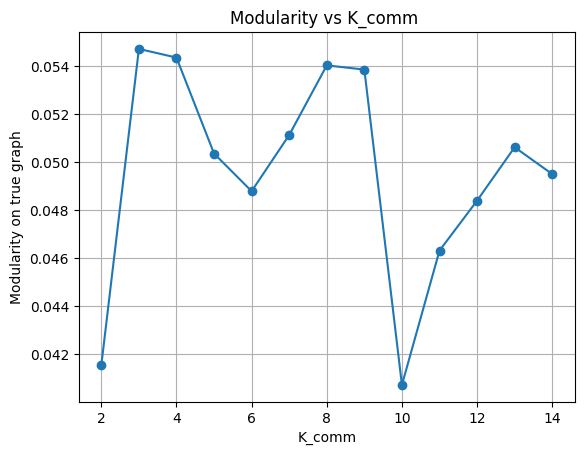

In [201]:
Ks = list(range(2, 15))
mods = []
ncomms = []
sizes_summary = []

for K in Ks:
    sc = SpectralClustering(
        n_clusters=K,
        affinity="precomputed",
        assign_labels="kmeans",
        random_state=0
    )
    z_hat = sc.fit_predict(Ahat)

    communities = []
    for k in range(K):
        comm_nodes = [nodes[i] for i in range(len(nodes)) if z_hat[i] == k]
        if len(comm_nodes) > 0:
            communities.append(set(comm_nodes))

    mod = modularity(G_small, communities)
    mods.append(mod)
    ncomms.append(len(communities))

    sizes = sorted([len(c) for c in communities], reverse=True)
    sizes_summary.append((sizes[0], np.median(sizes), sizes[-1]))

best_idx = int(np.argmax(mods))
best_K = Ks[best_idx]
print("Best K =", best_K, "modularity =", mods[best_idx])

plt.figure()
plt.plot(Ks, mods, marker="o")
plt.xlabel("K_comm")
plt.ylabel("Modularity on true graph")
plt.title("Modularity vs K_comm ")
plt.grid(True)
plt.show()



In [202]:
# best hyper-params
topk=10
cand_k=200
K_comm=best_K


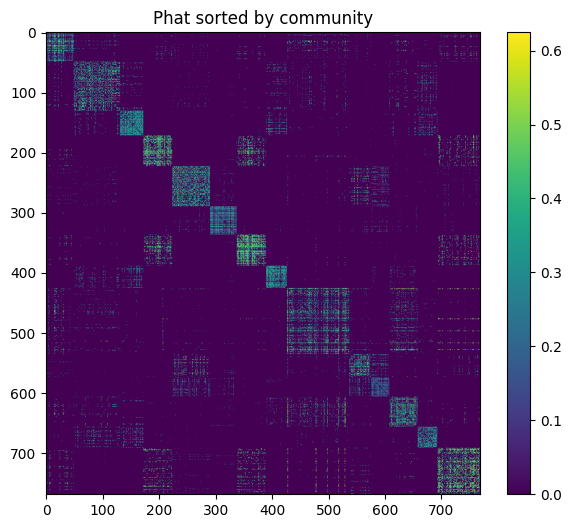

In [203]:
order = np.argsort(z_hat)
A_sorted = Ahat[np.ix_(order, order)]

sizes = [np.sum(z_hat == k) for k in range(len(np.unique(z_hat)))]
cuts = np.cumsum(sizes)

plt.figure(figsize=(7,6))
plt.imshow(A_sorted, aspect="auto")
#for cut in cuts[:-1]:
    #plt.axhline(cut-0.5)
    #plt.axvline(cut-0.5)
plt.title("Phat sorted by community")
plt.colorbar()
plt.show()

# Diffusion community generation

In [204]:
link_model=model

Ahat = build_Ahat_topk(link_model, X_t, topk=10, cand_k=200, device=device)
n = Ahat.shape[0]
print("Ahat density:", (Ahat>0).mean(), "max:", Ahat.max())


Ahat density: 0.021993334021012546 max: 0.6247137


In [205]:
edge_rc = np.argwhere(Ahat > 0)
edge_w  = Ahat[edge_rc[:,0], edge_rc[:,1]]

thr = np.quantile(edge_w, 0.8)
strong = edge_rc[edge_w >= thr]
strong = strong[strong[:,0] != strong[:,1]]
strong_t = torch.from_numpy(strong.astype(np.int64)).to(device)


In [206]:

A = Ahat.astype(np.float32)
rows, cols = np.nonzero(A)
vals = A[rows, cols]

self_idx = np.arange(n)
rows = np.concatenate([rows, self_idx])
cols = np.concatenate([cols, self_idx])
vals = np.concatenate([vals, np.ones(n, dtype=np.float32)])

deg = np.zeros(n, dtype=np.float32)
np.add.at(deg, rows, vals)
deg_inv_sqrt = 1.0 / np.sqrt(np.maximum(deg, 1e-8))
vals_norm = vals * deg_inv_sqrt[rows] * deg_inv_sqrt[cols]

indices = torch.from_numpy(np.vstack([rows, cols]).astype(np.int64)).to(device)
values  = torch.from_numpy(vals_norm).to(device)
A_sp = torch.sparse_coo_tensor(indices, values, (n, n)).coalesce()


In [207]:
class SparseGCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.lin = nn.Linear(in_dim, out_dim)
    def forward(self, A_sp, X):
        return self.lin(torch.sparse.mm(A_sp, X))

class CommunityDenoiser(nn.Module):
    def __init__(self, x_dim, K, hidden=256, z_emb=64):
        super().__init__()
        self.K = K
        self.z_embed = nn.Embedding(K, z_emb)
        self.g1 = SparseGCNLayer(x_dim + z_emb, hidden)
        self.g2 = SparseGCNLayer(hidden, hidden)
        self.out = nn.Linear(hidden, K)

    def forward(self, A_sp, X, z_t):
        H = torch.cat([X, self.z_embed(z_t)], dim=1)
        H = F.relu(self.g1(A_sp, H))
        H = F.relu(self.g2(A_sp, H))
        logits = self.out(H)
        Q = F.softmax(logits, dim=1)
        return Q

K = best_K
denoiser = CommunityDenoiser(x_dim=X_t.shape[1], K=K, hidden=256, z_emb=64).to(device)

B_param = nn.Parameter(torch.zeros(K, K, device=device))
params = list(denoiser.parameters()) + [B_param]
opt2 = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-4)


In [208]:
lambda_bal = 5
lambda_ent = 0.3
M_pairs = 8192

for ep in range(1, 201):
    denoiser.train()

    z_t = torch.randint(0, K, (n,), device=device)

    Q = denoiser(A_sp, X_t, z_t)

    if ep > 100:
        Q_used = harden_Q(Q, tau=0.5)
    else:
        Q_used = Q

    B_sig = torch.sigmoid(B_param)

    pairs, y = sample_pairs(M_pairs)
    p = recon_prob(Q_used, pairs, B_sig)

    loss_recon = F.binary_cross_entropy(p, y)
    loss_bal   = balance_loss(Q_used)
    loss_ent   = entropy_loss(Q_used)

    loss = loss_recon + lambda_bal * loss_bal - lambda_ent * loss_ent

    opt2.zero_grad()
    loss.backward()
    opt2.step()

    if ep % 10 == 0:
        denoiser.eval()
        with torch.no_grad():
            z_hard = Q_used.argmax(dim=1)
            uniq_est = int(z_hard.unique().numel())
        print(f"epoch {ep:03d} | recon {loss_recon.item():.4f} "
              f"bal {loss_bal.item():.4f} ent {loss_ent.item():.4f} "
              f"| used clusters {uniq_est}")


epoch 010 | recon 0.6909 bal 0.0001 ent 1.0983 | used clusters 3
epoch 020 | recon 0.6885 bal 0.0001 ent 1.0984 | used clusters 2
epoch 030 | recon 0.6860 bal 0.0000 ent 1.0986 | used clusters 3
epoch 040 | recon 0.6836 bal 0.0000 ent 1.0986 | used clusters 3
epoch 050 | recon 0.6813 bal 0.0000 ent 1.0986 | used clusters 3
epoch 060 | recon 0.6790 bal 0.0000 ent 1.0986 | used clusters 3
epoch 070 | recon 0.6767 bal 0.0000 ent 1.0986 | used clusters 3
epoch 080 | recon 0.6744 bal 0.0000 ent 1.0986 | used clusters 3
epoch 090 | recon 0.6723 bal 0.0000 ent 1.0986 | used clusters 3
epoch 100 | recon 0.6700 bal 0.0000 ent 1.0986 | used clusters 3
epoch 110 | recon 0.6680 bal 0.0004 ent 0.5046 | used clusters 3
epoch 120 | recon 0.6658 bal 0.0004 ent 0.5077 | used clusters 3
epoch 130 | recon 0.6637 bal 0.0002 ent 0.5064 | used clusters 3
epoch 140 | recon 0.6618 bal 0.0005 ent 0.4930 | used clusters 3
epoch 150 | recon 0.6598 bal 0.0001 ent 0.4988 | used clusters 3
epoch 160 | recon 0.6578 

In [209]:
@torch.no_grad()
def sample_communities(T=30, tau=1.0):
    denoiser.eval()
    z = torch.randint(0, K, (n,), device=device)
    for _ in range(T):
        Q = denoiser(A_sp, X_t, z)
        probs = (Q ** (1.0/tau))
        probs = probs / probs.sum(dim=1, keepdim=True)
        z = torch.multinomial(probs, num_samples=1).squeeze(1)
    return z.detach().cpu().numpy()

z_gen = sample_communities(T=50, tau=1.0)
print("generated unique clusters:", np.unique(z_gen), "count:", len(np.unique(z_gen)))


generated unique clusters: [0 1 2] count: 3


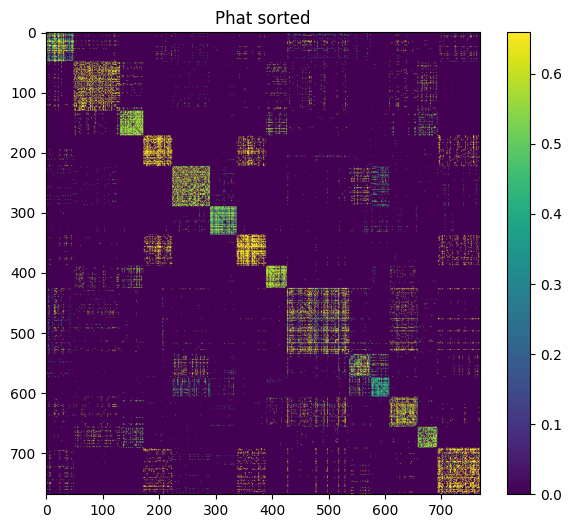

In [210]:
A_view = np.sqrt(A_sorted)
vmax = np.quantile(A_view, 0.99)

plt.figure(figsize=(7,6))
plt.imshow(A_view, aspect="auto", vmin=0.0, vmax=vmax)
plt.title("Phat sorted")
plt.colorbar()
plt.show()


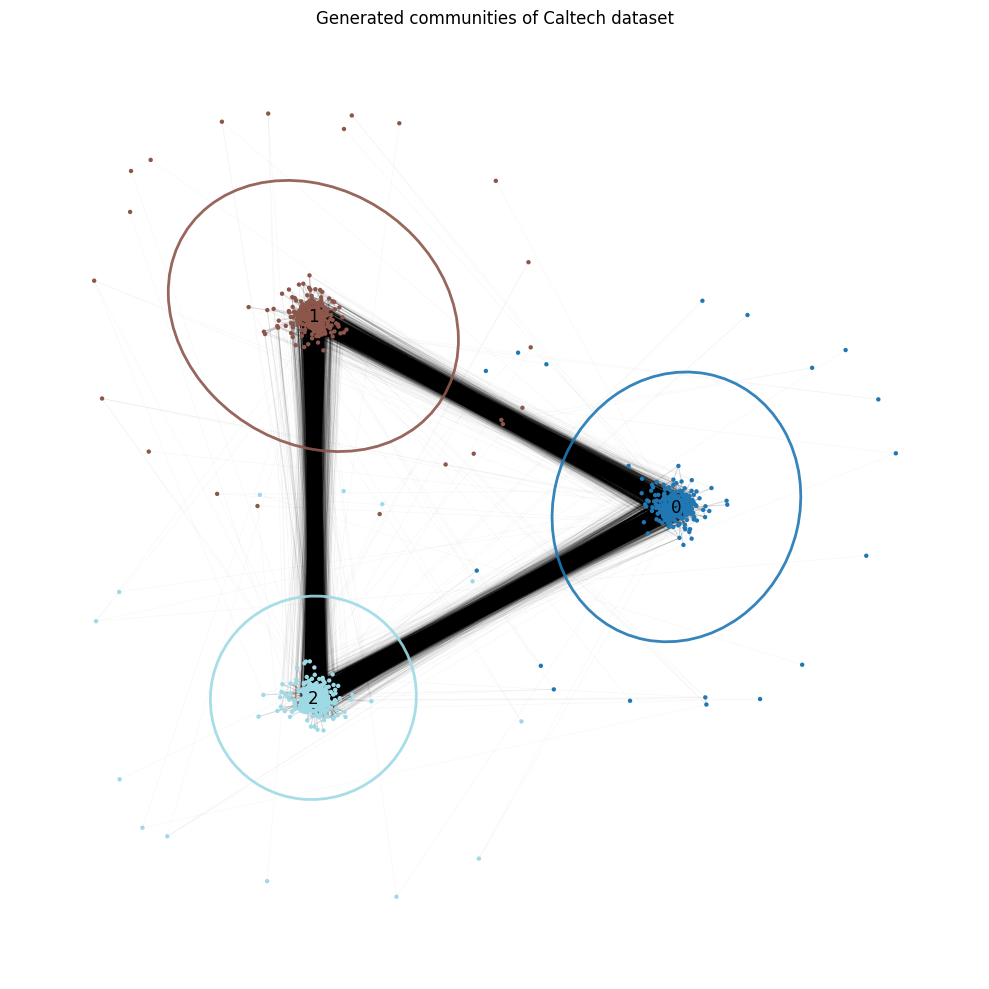

In [211]:
draw_communities_graph(G_small, nodes, z_gen, seed=0, scale=1.0,
                       node_size=10, edge_alpha=0.03, intra_edge_alpha=0.12,
                       draw_inter_edges=True)